In [ ]:
import ntpath
import os
import time

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers
from tensorflow import keras

# Utility functions

In [ ]:
def reconvert_labels(labels):
    instruments = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
    return np.asarray([instruments[label] for label in labels])

# From .wav to mel spectrogram

In [ ]:
def get_mel(filename, plot=False, test=False):
    # load audio
    samples, sample_rate = librosa.load(filename, sr=None)
    if plot:
        # x-axis has been converted to time using our sample rate.
        # matplotlib plt.plot(y), would output the same figure, but with sample
        # number on the x-axis instead of seconds
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(samples, sr=sample_rate)
        plt.show()

    # print('Example shape ', samples.shape, 'Sample rate ', sample_rate, 'Data type', type(samples))
    # print(samples[22400:22420])

    shape = samples.shape[0]
    if test:
        seconds = round(shape / sample_rate) - 1
    else:
        seconds = round(shape / sample_rate)

    audio_samples = [samples[i * sample_rate: ((i + 1) * sample_rate) - 1] for i in range(seconds)]
    # audio_samples = [samples[0:sample_rate], samples[sample_rate:2 * sample_rate], samples[2 * sample_rate:]]

    mel_sgrams = []
    for audio_sample in audio_samples:

        # get spectogram
        sgram = librosa.stft(audio_sample)
        # if plot:
        #     librosa.display.specshow(sgram)
        #     plt.show()

        # use the mel-scale instead of raw frequency
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
        # if plot:
        #     librosa.display.specshow(mel_scale_sgram)
        #     plt.show()

        # use the decibel scale to get the final Mel Spectrogram
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        mel_sgrams.append(mel_sgram)
        if plot:
            librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.show()

    return mel_sgrams

def get_test_mel(file, plot=False):
    mel_specs = []

    mel_specs.extend(get_mel(file, plot, test=True))

    return mel_specs

def get_label(file):
    with open(file) as f:
        label = f.readline().rstrip()
    return label

# Example

In [ ]:
import IPython
IPython.display.Audio('./dataset/IRMAS-TestingData/Part3/02 Stardust-1.wav')

In [ ]:
label = get_label('./dataset/IRMAS-TestingData/Part3/02 Stardust-1.txt')
label

'tru'

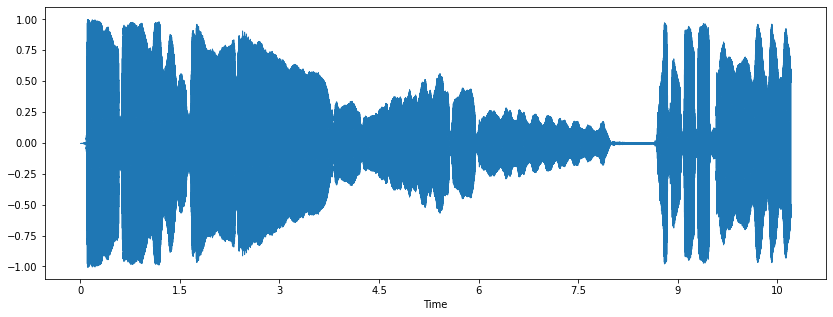

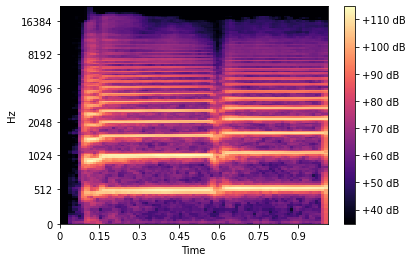

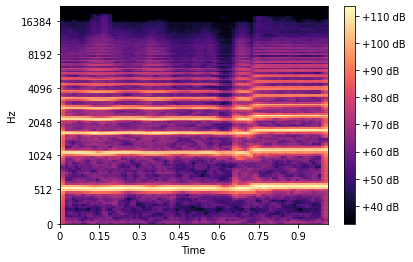

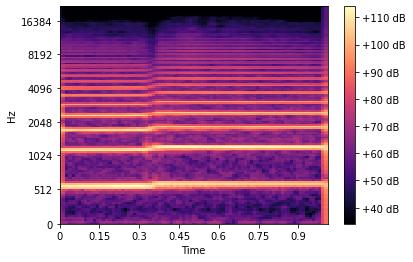

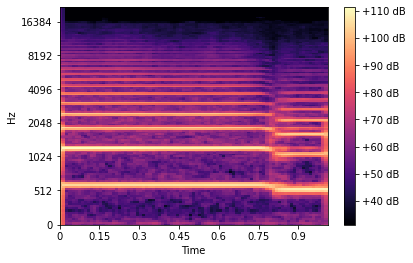

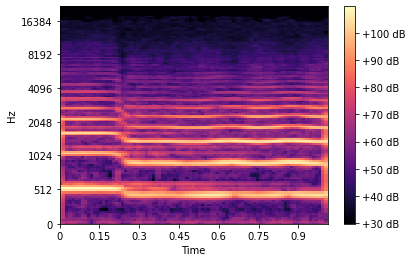

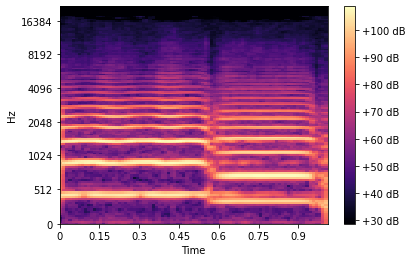

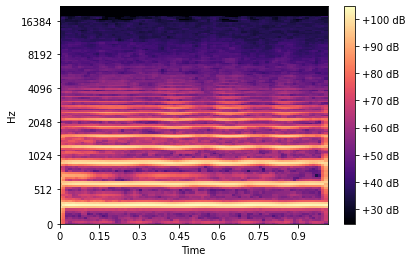

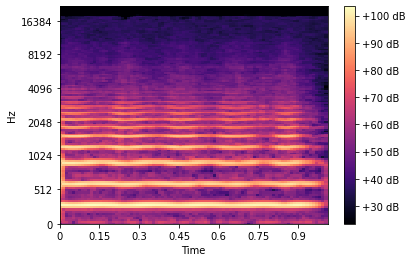

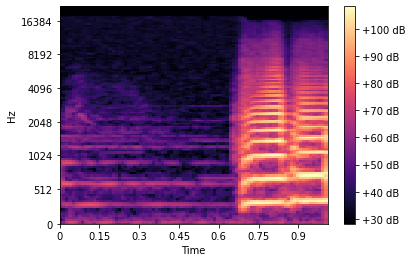

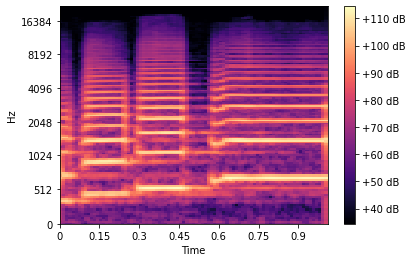

(10, 128, 87, 1)

In [ ]:
data = []
mel_specs = get_test_mel('./dataset/IRMAS-TestingData/Part3/02 Stardust-1.wav', plot=True)
X = np.reshape(np.asarray(mel_specs), [-1, 128, 87, 1])
X.shape

# Load model + predict

In [ ]:
model = keras.models.load_model('./model')

y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_pred_classes = reconvert_labels(y_pred_classes)
y_pred_classes

array(['pia', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'pia',
       'tru'], dtype='<U3')

In [ ]:
unique, counts = np.unique(y_pred_classes, return_counts=True)
probabilities = np.asarray((unique, counts/len(y_pred_classes))).T
probabilities[probabilities[:, 1].argsort()]

array([['pia', '0.2'],
       ['tru', '0.8']], dtype='<U32')